<a href="https://colab.research.google.com/github/taravatp/Facial_Keypoint_Detection/blob/main/train_pretrained_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing packages

In [ ]:
cd "/content/drive/MyDrive/facial_keypoint_detection/"

/content/drive/MyDrive/facial_keypoint_detection


In [ ]:
!pip install import_ipynb 

In [ ]:
import torchvision
from torchvision import models,datasets,transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np,pandas as pd,os,glob,cv2
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader,Dataset,TensorDataset
from sklearn import cluster
from sklearn.model_selection import train_test_split

import import_ipynb

In [ ]:
import dataset 
from dataset import facial_keypoint

In [ ]:
!pip install torch_summary
from torchsummary import summary

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# preparing data


In [ ]:
data_directory ='/content/drive/MyDrive/facial_keypoint_detection/P1_Facial_Keypoints/data/training/'
data = pd.read_csv('/content/drive/MyDrive/facial_keypoint_detection/P1_Facial_Keypoints/data/training_frames_keypoints.csv')
train, test = train_test_split(data,test_size=0.2,random_state=101)

train_data = facial_keypoint(train.reset_index(drop=True),data_directory) #reset index reuslts in all the indices start from 0
test_data = facial_keypoint(test.reset_index(drop=True),data_directory)

data_loader_train = DataLoader(train_data,batch_size=32)
data_loader_test = DataLoader(test_data,batch_size=32)

# Defining model

In [ ]:
model = models.vgg16(pretrained=True)
for param in model.parameters():
  param.requires_grad = False
model.avgpool = nn.Sequential(
    nn.Conv2d(512,512,3),
    nn.MaxPool2d(2),
    nn.Flatten()
)
model.classifier = nn.Sequential(
    nn.Linear(2048,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,136),
    nn.Sigmoid()
)
model = model.to(device)

#Defining loss function, optimizer and hyper-parameters

In [ ]:
loss_function = nn.L1Loss()
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
epochs = 6

#Training

In [ ]:
train_loss = []
test_loss = []
RMSE_accuracy = []
for epoch in range(epochs):
  print("epoch number:",epoch)

  epoch_train_loss = 0
  for iteration,(image,keypoints) in enumerate(data_loader_train):
    model.train()
    optimizer.zero_grad()
    prediction = model(image.to(device))
    batch_loss = loss_function(prediction,keypoints)
    batch_loss.backward()
    optimizer.step()
    epoch_train_loss += batch_loss.item()
  train_loss.append(epoch_train_loss/(iteration+1))
  print(f"train loss:{epoch_train_loss/(iteration+1)}")

  epoch_test_loss = 0
  for iteration,(image,keypoints) in enumerate(data_loader_test):
    model.eval()
    prediction = model(image.to(device))
    test_batch_loss = loss_function(prediction,keypoints)
    epoch_test_loss += test_batch_loss.item()
  test_loss.append(epoch_test_loss/(iteration+1))
  print(f"test loss:{epoch_test_loss/(iteration+1)}")

  losses = []
  #num_emxamples = 0
  for iteration, (image,keypoints) in enumerate(data_loader_test):
    model.eval()
    prediction = model(image.to(device))
    rmse = nn.MSELoss()(prediction,keypoints)
    #num_emxamples += prediction.shape[0]
    losses.append(rmse)
  RMSE_accuracy.append(sum(losses) ** 0.5)
  print(f"RMSE accuracy:{sum(losses) ** 0.5}")
  torch.save(model.state_dict(),f"model_epoch:{epoch}")

epoch number: 0
train loss:0.08044442080560772
test loss:0.05510260638865558
RMSE accuracy:0.33525604009628296
epoch number: 1
train loss:0.06405689939856529
test loss:0.04735221832313321
RMSE accuracy:0.28742140531539917
epoch number: 2
train loss:0.05905998117108455
test loss:0.044339830902489746
RMSE accuracy:0.2698953151702881
epoch number: 3
train loss:0.0558569118723102
test loss:0.04209511625495824
RMSE accuracy:0.2570517957210541
epoch number: 4
train loss:0.053146249646770546
test loss:0.040160367604006424
RMSE accuracy:0.24607890844345093
epoch number: 5
train loss:0.050813341491866386
test loss:0.03864865309812806
RMSE accuracy:0.23739324510097504


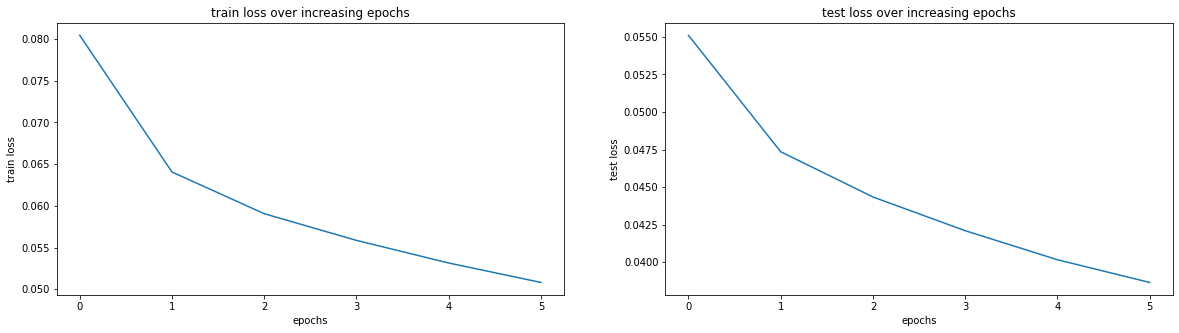

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('train loss over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.plot(train_loss)
plt.subplot(122)
plt.title('test loss over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('test loss')
plt.plot(test_loss)